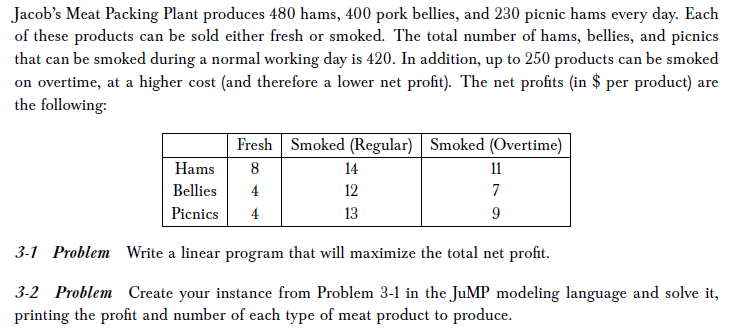

In [ ]:
products = [:ham, :bellies, :picnic]
cooking_type = [:fresh, :regular, :smoked]

limit_product = Dict(zip(products, [480, 400, 230]))

cost_matrix = [
    8 14 11
    4 12 7
    4 13 9
]

A_NA = NamedArray(cost_matrix, (products, cooking_type), ("product", "type"));


m32 = Model(HiGHS.Optimizer)

@variable(m32, x[products, cooking_type] >= 0)

@constraint(m32, [i in products] , sum(x[i, j] for j in cooking_type) <= limit_product[i])
@constraint(m32, sum(x[i, :regular] for i in products) <= 420)
@constraint(m32, sum(x[i, :smoked] for i in products) <= 250)

@objective(m32, Max, sum(A_NA[i, j] * x[i, j] for i in products, j in cooking_type))

# solve the problem
set_silent(m32)
optimize!(m32)

# display the output
println("Total profit will be \$", objective_value(m32))
for i in products
    for j in cooking_type
        if value(x[i, j]) > 0
            println("The number of product","$([i, j]): = ", value(x[i, j]))
        end
    end
end

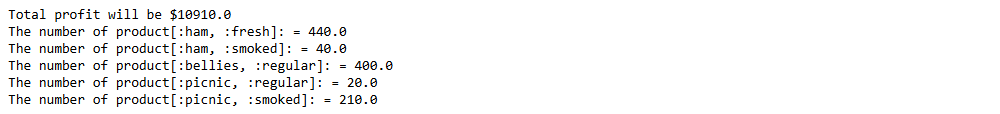

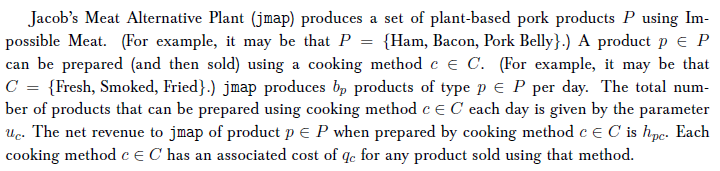

In [ ]:
using DataFrames, CSV, NamedArrays
df = CSV.read("pork-general.csv", DataFrame, delim =',')

cook_type = propertynames(df)[3:end]
product = convert(Array, df[3:end,1])

max_daily_product = Dict(zip(product,df[3:end,2]))
max_daily_cook = Dict(zip(cook_type,df[1,3:end]))
proc_cost = Dict(zip(cook_type,df[2,3:end]))

h = Matrix(df[3:end,3:end])
h_NA = NamedArray(h, (product, cook_type), ("Product", "Cook Type")) ;


m42 = Model(HiGHS.Optimizer)

@variable(m42, x[product, cook_type] >= 0)

@constraint(m42, [i in product], sum(x[i, j] for j in cook_type) <= max_daily_product[i])
@constraint(m42, [j in cook_type], sum(x[i, j] for i in product) <= max_daily_cook[j])

@objective(m42, Max, sum((h_NA[i, j] - proc_cost[j]) *x[i, j]  for i in product, j in cook_type))

# solve the problem
set_silent(m42)
optimize!(m42)

# display the model
println("Total profit will be \$", objective_value(m42))

for i in product
    for j in cook_type
        if value(x[i, j]) > 0
            println("$(sum(x[i, j])): = ", value(x[i, j]))
        end
    end
end

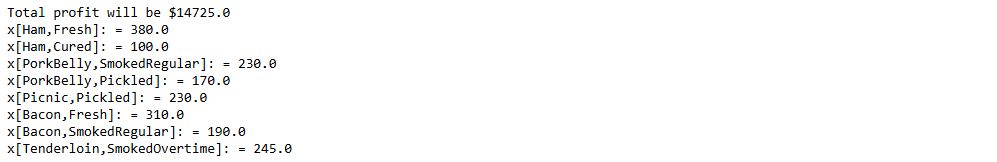

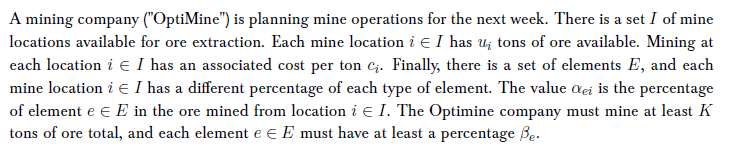

In [ ]:
using DataFrames, CSV, NamedArrays

#Load the CSV data file (should be in same directory as notebook)
df = CSV.read("optimine.csv",DataFrame,delim= ',');
# create a list of mines
mines = convert(Array,df[2:end,1])

# create a list of elements
# here we take from the DataFrame header (into Julia Symbol)
elements = propertynames(df)[2:6]

# create a dictionary of the total cost of mining at each location
c = Dict(zip(mines,df[2:end,7]))

# create a dictionary of the max tons available at each location
u = Dict(zip(mines,df[2:end,8]))

# create a dictionary of the amount required of each element
β = Dict(zip(elements,df[1,2:6]))

# create a matrix of the % of each element at each loation
mine_element_matrix = Matrix(df[2:end,2:6])

# rows are mines, columns are elements
α = NamedArray(mine_element_matrix, (mines, elements), ("mines","elements"))

K = 3000 ;



m53 = Model(HiGHS.Optimizer)

@variable(m53, x[mines] >= 0)
@objective(m53, Min, sum(x[i] * c[i] for i in mines))

@expression(m53, production, sum(x[i] for i in mines))
@constraint(m53, production >= K)

@constraint(m53, [i in mines], x[i] <= u[i])

@constraint(m53, [j in elements], sum(α[i, j] * x[i] for i in mines) >= β[j]*production)

# solve the problem
set_silent(m53)
optimize!(m53)


# display the model
println("Minimum cost of production will be \$", objective_value(m53))
for i in x
    println("$(i) = ", value(i), "tons")
end

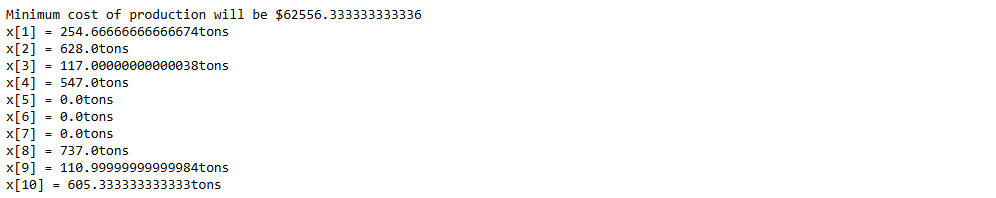

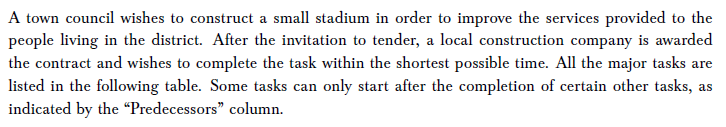
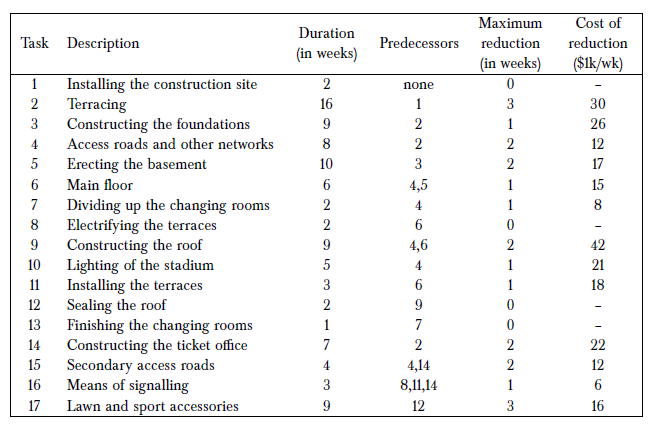

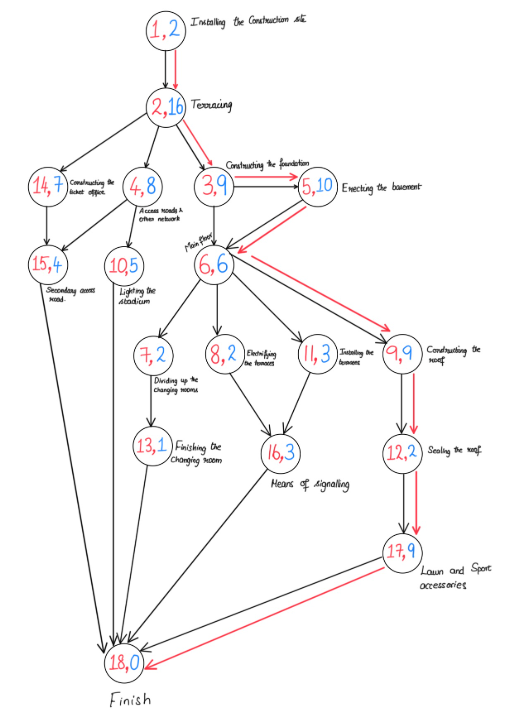

In [ ]:
using JuMP, HiGHS

tasks = 1:18
durations = [2 16 9 8 10 6 2 2 9 5 3 2 1 7 4 3 9 0]
predecessors = ( [], [1], [2], [2], [3], [4,5], [4], [6], [4,6], [4], [6], 
                [9], [7], [2], [4,14], [8,11,14], [12], [10, 13, 15, 16, 17])
pred_dict = Dict(zip(tasks,predecessors));   # dictionary mapping tasks --> predecessors.

m33 = Model(HiGHS.Optimizer)

@variable(m33, tstart[tasks])

# one-line implementation of the constraints:
@constraint(m33, link[i in tasks, j in predecessors[i]], tstart[i] >= tstart[j] + durations[j])

@constraint(m33, tstart[1] == 0)

# total duration is start time of last task + duration of last task.   
#In this case, we know that :x is the last task, but in general, 
#we must write this constraint for every task 
#(or at least every task at the end of a chain in the parital order defined by the precedence)

@objective(m33, Min, tstart[18] + durations[18])   

optimize!(m33)
println(value.(tstart))
println("minimum duration: ", objective_value(m33))


for i in tasks
    for j in predecessors[i]
       slack = value(tstart[i]) - value(tstart[j]) - durations[j];
        dualval = dual(link[i, j])
        if (slack <= .00001)
            println("task ", i, " predecessor ",j, "  slack is : ", slack, " Dual: ", dualval, " ***ACTIVE")
        else
             println("task ", i, " predecessor ",j, "  slack is : ", slack, " Dual: ", dualval)
        end
    end
end

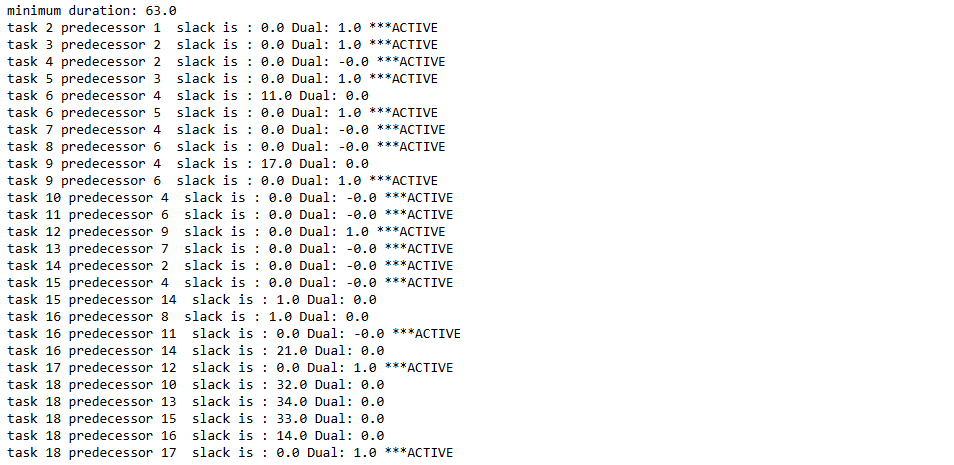